# Defining geometries for PyMEEP

Simple shapes can be directly defined in PyMEEP. Later, we will see how to import arbitrary shapes made with more specialized tools.
For visualization, we will call the Python packages [Matplotlib](https://matplotlib.org/) and [Ipyvolume](https://ipyvolume.readthedocs.io/en/latest/).

References :

1. https://mpb.readthedocs.io/en/latest/Python_Tutorial/
2. https://mpb.readthedocs.io/en/latest/Python_User_Interface/
2. http://www.simpetuscloud.com/projects.html#mpb_waveguide

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt
import ipyvolume as ipv

# Cross-section of a strip waveguide

As a (useful) example, let's characterize a strip waveguide (Figure from [3])

![alt text](http://www.simpetus.com/files/SOI_waveguide_bands.png)

The left image is the geometry we want to simulate. Since we have translational invariance along $x$, the propagation direction, we will only consider the $yz$ cross-section. The right image contains the information we want : dispersion relation (allowed modes), and field profiles.

## 1. Computational domain

Since the computer has finite memory, our geometry will live inside a "super" geometry. For MPB, this "supercell" always has periodic boundary conditions. But if it is big enough, we don't expect it to have an effect on localized modes, which is what we are trying to solve for a waveguide.

### 1.1 A note on geometry

By default, everything is 3D. For a waveguide, we can use the translational invariance along the propagation direction (say, $x$) to do a 2D simulation. Then, the only thing that matters is the geometries' intersection with the yz plane (x=0). We can set this when we define the size of the computational cell, controlled by the geometry_lattice argument, an object of the meep.Lattice class: we can set some of the dimensions to have a size 0, which reduces the dimensionality of the system. [1]

### 1.2 A note on units

Since Maxwell's equations with linear permittivity are [scale-invariant](https://mpb.readthedocs.io/en/latest/Python_Tutorial/#a-few-words-on-units), a simulation in MPB with units of $x$ outputs frequencies equivalent to $f=x/\lambda$. By default, dimensions are in microns. For instance, to look for the wavelength response at $1.5\mu$m, we look at frequency $1/1.5 = 0.6667$ (the physical frequency outside of MPB would be $f=c/\lambda$).

Let's define the supercell :

In [2]:
sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 64  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z)) # Computational domain object

Here, we used variables to parametrize the supercell. The resolution should be a multiple of 2 for better results.

In [3]:
# Parameters for the waveguide
w = 0.3  # Si width (um)
h = 0.25  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

## 2. Geometry

The geometry that will be passed to the solver is a list of meep objects. Objects typically have a shape and index. Later objects in the list will be overlaid "on top" of earlier objects, effectively replacing them (useful to draw holes). See https://meep.readthedocs.io/en/latest/Python_User_Interface/#geometricobject for common geometries.

In [4]:
# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5 * (sc_z - h)),
                     center=mp.Vector3(z=0.25 * (sc_z + h)), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, w, h), material=Si)]

## 3 - Visualizing the geometry

While we could directly convert the geometry object above into a visualization, MPB and MEEP offer an easy way to display the dielectric distribution once the simulation has been initialized. The function we are interested in is `ModeSolver.init_params(p, reset_fields)` [2]

In [5]:
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution)
ms.init_params(mp.NO_PARITY, True)

Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.3,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...


Let's ask the modesolver for the permittivity distribution it will simulate and plot it :

epsilon: 1-11.9025, mean 1.68727, harm. mean 1.33783, 47.4609% > 1, 6.30378% "fill"


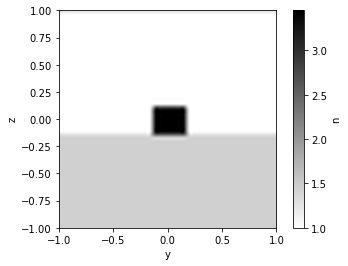

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())

pos = ax.imshow(n.T, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

# 2.5D photonic crystal

It is just as easy to define different elements and to extend to 3D. The periodic boundary conditions of MPB make a cell containing a single element automatically a photonic crystal. To simulate defect modes, one can proceed as above i.e. have a larger computational domain with the bounded mode decaying before reaching the boundary.


In [45]:
# Supercell
sc_x = 0.5 # um
sc_y = 0.5 # um
sc_z = 2 # um
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(sc_x, sc_y, sc_z)) # Computational domain object

# Objects
geometry = [mp.Cylinder(radius=0.2, height=0.5 * (sc_z - h), material=Si)] # 200nm radius cylinder

# ModeSolver
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution)
ms.default_material = SiO2 # Default fill for background
ms.init_params(mp.NO_PARITY, True)

Working in 3 dimensions.
Grid size is 16 x 16 x 64.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.5, 0, 0)
     (0, 0.5, 0)
     (0, 0, 2)
Cell volume = 0.5
Reciprocal lattice vectors (/ 2 pi):
     (2, -0, 0)
     (-0, 2, -0)
     (0, -0, 0.5)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.2, height 0.875, axis (0, 0, 1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...


epsilon: 2.1025-11.9025, mean 4.25806, harm. mean 2.62689, 100% > 1, 21.9955% "fill"
(16, 16, 64)


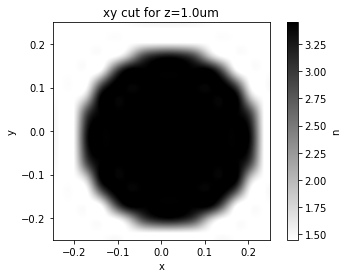

In [72]:
fig, ax = plt.subplots(1,2,figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())
print(np.shape(n))
nxy = n[:,:,int(sc_z*resolution/2)]

pos = ax.imshow(nxy, cmap='gray_r', interpolation='spline36', extent=[-sc_x/2,sc_x/2,-sc_y/2,sc_y/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_title('xy cut for z={0}um'.format(sc_z/2))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

epsilon: 2.1025-11.9025, mean 4.25806, harm. mean 2.62689, 100% > 1, 21.9955% "fill"
(16, 16, 64)


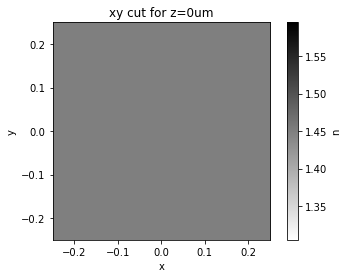

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())
print(np.shape(n))
nxy = n[:,:,0]

pos = ax.imshow(nxy, cmap='gray_r', interpolation='spline36', extent=[-sc_x/2,sc_x/2,-sc_y/2,sc_y/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_title('xy cut for z={0}um'.format(0))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [47]:
ipv.quickvolshow(n, level=[0,1.45,3.45])